This notebook helps to learn how to build a basic image classification system from scratch, and progressively improve it using higher levels of abstraction and finally using the learner module in fastai. We choose a problem that is similar to MNIST digit classification, but slightly different to allow a deeper understanding of building an end-to-end solution on a "not-so-familiar" dataset. The model has to classify handwritten music symbol image into one of the 5 classes namely whole note, half note, quarter note, eighth note and sixteenth note. 

In [17]:
from fastai.vision.all import *
from fastbook import *

In [18]:
dataset_path = Path('/home/jobin/exploration/datasets/NotesDataset/Notes')

In [26]:
## start with simple problem => 2 class problem to differentiate half note from quarter note ##
quarters = (dataset_path/'Quarter').ls().sorted()
halfs = (dataset_path/'Half').ls().sorted()

In [27]:
quarters[0],halfs[0]

(Path('Notes/Quarter/q1.jpg'), Path('Notes/Half/h1.jpg'))

<Axes: title={'center': 'quarter note'}>

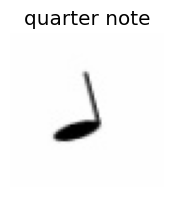

In [50]:
show_image(Image.open(quarters[0]),title="quarter note")

<Axes: title={'center': 'half note'}>

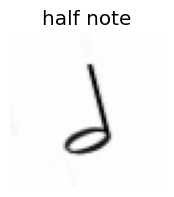

In [52]:
show_image(Image.open(halfs[0]),title="half note")

In [69]:
## load into a tensor and see how it looks ##
quarter_tens = tensor(Image.open(quarters[0]).convert('L')) ## convert to grey scale
quarter_tens.shape ## each input is a 64X64 grey-scale image

torch.Size([64, 64])

In [75]:
## plot a portion ##
df = pd.DataFrame(quarter_tens[15:55,15:45])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
0,254,254,254,254,254,254,254,254,254,254,255,254,253,253,253,248,242,253,253,253,254,254,254,254,254,254,254,254,254,254
1,254,254,254,254,254,254,254,254,254,254,254,254,251,254,252,198,132,206,252,254,253,251,255,254,254,254,254,254,254,254
2,254,254,254,254,254,254,254,254,254,255,255,254,255,254,244,184,74,136,251,255,255,255,253,254,255,254,254,254,254,254
3,254,254,254,254,254,254,254,254,254,253,253,251,254,254,255,224,89,76,255,254,250,254,255,255,252,254,254,254,254,254
4,254,254,254,254,254,254,254,254,254,255,255,255,253,251,254,245,115,46,237,254,254,252,255,253,255,254,254,254,254,254
5,254,254,254,254,254,254,254,254,254,253,254,255,255,255,255,252,150,58,184,252,255,255,254,251,255,254,254,254,254,254
6,254,254,254,254,254,254,254,254,254,254,254,253,251,253,252,250,192,80,123,255,253,255,252,254,253,254,254,254,254,254
7,254,254,254,254,254,254,254,254,254,253,255,254,255,255,253,253,230,91,71,252,255,253,253,255,255,254,254,254,254,254
8,254,254,254,254,254,254,254,254,254,253,255,251,254,253,253,255,248,123,45,227,253,252,255,251,254,254,254,254,254,254
9,254,254,254,254,254,254,254,254,254,254,254,254,254,254,254,253,252,158,66,171,252,255,252,255,254,254,254,254,254,254


## approach-1 => simple pattern matching ##
1. load all half-notes into a tensor and calculate "avergae" half-note image
2. Load all quarter-notes into a tensor and calculate "avergae" quarter-note image
3. for any incoming image, check distance between the "average" images and predict the class as the closer one

In [93]:
half_tensor = torch.stack([tensor(Image.open(img).convert('L')) for img in halfs])/255.0
quarter_tensor = torch.stack([tensor(Image.open(img).convert('L')) for img in quarters])/255.0

In [94]:
half_tensor.shape,quarter_tensor.shape

(torch.Size([1000, 64, 64]), torch.Size([1000, 64, 64]))

(<Axes: >, <Axes: >)

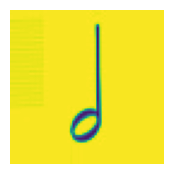

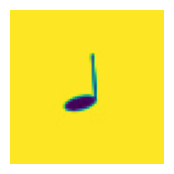

In [95]:
show_image(half_tensor[1]),show_image(quarter_tensor[1])

In [101]:
mean_halfnote = half_tensor.mean(dim=0)
mean_quarternote = quarter_tensor.mean(dim=0)

<Axes: title={'center': 'mean quarter-note'}>

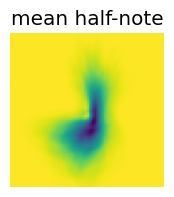

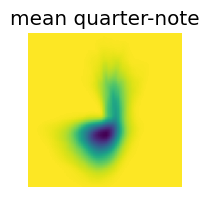

In [102]:
show_image(mean_halfnote,title='mean half-note')
show_image(mean_quarternote,title='mean quarter-note')

In [103]:
query_image = quarter_tensor[-1]

In [106]:
## compute l1-distance between query image and mean image, and predict the class ##
F.l1_loss(query_image,mean_quarternote),F.l1_loss(query_image,mean_halfnote)

(tensor(0.0594), tensor(0.0634))

In [109]:
def is_quarter_note(img_tensor):
    return F.l1_loss(img_tensor,mean_quarternote) < F.l1_loss(img_tensor,mean_halfnote)

In [110]:
is_quarter_note(query_image)

tensor(True)